In [20]:
import keras
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from arff2pandas import a2p
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint
from matplotlib import pyplot
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers.recurrent import LSTM
from keras.layers  import LeakyReLU
from keras.layers  import Conv1DTranspose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
RANDOM_SEED = 42
PCA_COMPONENT_DATA_1=6

epochs=30
patience=5

In [22]:
# Dataset_1: Physionet's MIT-BIH Arrhythmia Dataset,
# The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, 
# obtained from 47 subjects  
# Applied PCA on the data
def load_dataset_1_pca():

    CLASS_NORMAL = 0
    timesteps=187
    #Load Data
    train=pd.read_csv('data/mit/mitbih_train.csv',header=None)
    test=pd.read_csv('data/mit/mitbih_test.csv',header=None)
    
    # Data Preprocessing
    train[timesteps]=train[timesteps].astype(int)
    train[timesteps]=train[timesteps].astype(int)
    test[timesteps]=test[timesteps].astype(int)
    data_splits=train[timesteps].value_counts()
    df = train.append(test)
    df = df.sample(frac=1.0)
    df[timesteps]=df[timesteps].astype(int)
    class_counts=df[timesteps].value_counts()
    class_names = ['N','Q','V','S','F']
    new_columns = list(df.columns)
    new_columns[-1] = 'target'
    df.columns = new_columns
    #Plot data sub-types and counts
    
    print('Data Sub-Types and Counts')
    sn_instance = sns.countplot(df.target)
    sn_instance.set_xticklabels(class_names);
    plt.show()
    classes = df.target.unique()
    fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
    )

    for i, cls in enumerate(classes):
     sn_instance = axs.flat[i]
     data = df[df.target == cls] \
     .drop(labels='target', axis=1) \
     .mean(axis=0) \
     .to_numpy()
     plot_ts_data(data, class_names[i], sn_instance)

    fig.delaxes(axs.flat[-1])
    fig.tight_layout();
    plt.show()
    normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
    print('Merged Normal Shape',normal_df.shape)
    
        
    #Preprocess normal data and perform PCA transformation
    pca_instance = PCA(n_components=PCA_COMPONENT_DATA_1)
    normal_pca= pca_instance.fit_transform(normal_df.values)
    
    test_anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
    print('Anomaly Shape',test_anomaly_df.shape)
    
    #Preprocess anomaly data and standardize anomaly data
    anomaly_transformed = StandardScaler().fit_transform(test_anomaly_df.values)
    
    #Preprocess anomaly data and perform PCA transformation
    anomaly= pca_instance.fit_transform(anomaly_transformed)
    train_normal,test_normal=split_train_normal(normal_pca)
    x_train,x_test_normal,x_test_anomaly = transform_df_to_lists_pca(train_normal,test_normal,anomaly,PCA_COMPONENT_DATA_1)
    return x_train,x_test_normal,x_test_anomaly   

In [23]:
# Dataset_2: Physionet's MIT-BIH Arrhythmia Dataset,
# The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, 
# obtained from 47 subjects  
# No PCA 
def load_dataset_1():

    CLASS_NORMAL = 0
    timesteps=187
  
    train=pd.read_csv('data/mit/mitbih_train.csv',header=None)
    test=pd.read_csv('data/mit/mitbih_test.csv',header=None)
    # Data Preprocessing
    train[timesteps]=train[timesteps].astype(int)
    train[timesteps]=train[timesteps].astype(int)
    test[timesteps]=test[timesteps].astype(int)
    data_splits=train[timesteps].value_counts()
    print(data_splits)
    df = train.append(test)
    df = df.sample(frac=1.0)
    df[timesteps]=df[timesteps].astype(int)
    class_counts=df[timesteps].value_counts()
    print(class_counts)
    class_names = ['N','Q','V','S','F']
    new_columns = list(df.columns)
    new_columns[-1] = 'target'
    df.columns = new_columns
    ax = sns.countplot(df.target)
    ax.set_xticklabels(class_names);
    classes = df.target.unique()
    normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
    print('Normal Shape',normal_df.shape)
    test_anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
    print('Anomaly Shape',test_anomaly_df.shape)
    train_normal_df,test_normal_df=split_train_normal(normal_df)
    x_train,x_test_normal,x_test_anomaly = transform_df_to_lists (train_normal_df,test_normal_df,test_anomaly_df,timesteps)
    return x_train,x_test_normal,x_test_anomaly

#Converts dataframes into lists

def transform_df_to_lists (train_normal_df, test_normal_df , test_anomaly_df,timesteps):
    x_train=train_normal_df.values.tolist()
    x_train=np.asarray(x_train, dtype=np.float32) 
    x_train = x_train.reshape((x_train.shape[0], timesteps, 1))
    print(x_train.shape)

    x_test_normal=test_normal_df.values.tolist()
    x_test_normal=np.asarray(x_test_normal, dtype=np.float32) 
    x_test_normal = x_test_normal.reshape((x_test_normal.shape[0], timesteps, 1))
    print(x_test_normal.shape)

    x_test_anomaly=test_anomaly_df.values.tolist()
    x_test_anomaly=np.asarray(x_test_anomaly, dtype=np.float32) 
    x_test_anomaly = x_test_anomaly.reshape((x_test_anomaly.shape[0], timesteps, 1))
    print(x_test_anomaly.shape)
    return x_train,x_test_normal,x_test_anomaly

In [24]:
# Model#1 with consisting of LSTM,Conv1D. Used sigmoid activation and mse loss. Used relu activation and binary crossentropy loss. 

def get_model_1 (dim1, dim2,dataset_name):
    
    inputs = Input(shape=(dim1, dim2))
    x = Conv1D(64, 5, padding="same",activation="relu")(inputs)
    x = LSTM(64,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, padding="same",activation="relu")(x)
    x = Conv1DTranspose(64, 5, padding="same",activation="relu")(x)
    x = Dropout(0.2)(x)
    x = LSTM(32,return_sequences=True)(x)
    x = Conv1DTranspose(64,5, padding="same",activation="relu")(x)
    outputs = Conv1DTranspose(1, 5, padding="same", activation="relu")(x)

    model = keras.Model(inputs, outputs, name='model_1_'+dataset_name)
    model.summary()
    plot_model(model, show_shapes=True, to_file='Model1.png')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy")
  
    return model

In [25]:
# Model#2 with consisting of LSTM,Conv1D. Used sigmoid activation and mse loss. 

def get_model_2 (dim1, dim2,dataset_name):
    
    inputs = Input(shape=(dim1, dim2))
    x = Conv1D(64, 5, padding="same",activation="relu")(inputs)
    x = LSTM(64,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, padding="same",activation="relu")(x)
    x = Conv1DTranspose(64, 5, padding="same",activation="relu")(x)
    x = Dropout(0.2)(x)
    x = LSTM(64,return_sequences=True)(x)
    x = Conv1DTranspose(64,5, padding="same",activation="relu")(x)
    outputs = Conv1DTranspose(1, 5, padding="same", activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name='model_2_'+dataset_name)
    model.summary()
    plot_model(model, show_shapes=True, to_file='Model2.png')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
  
    return model

In [26]:
#Train a model with early-stopping with patience and checkpointing.
def train_model(x_train,model,epochs,model_checkpoint_callback):
    
  esCallback = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1)
  history = model.fit(x_train,x_train ,epochs=epochs, batch_size = 300,validation_split=0.2,verbose=1,callbacks=[model_checkpoint_callback,esCallback],shuffle=True)  
  return history

In [27]:
#Plot time series data
def plot_ts_data(input_data, category, instance, n_steps=10):
  time_series_df = pd.DataFrame(input_data)

  path = time_series_df.rolling(n_steps).mean()
  deviation = 2 * time_series_df.rolling(n_steps).std()

  line_under = (path - deviation)[0]
  line_above = (path + deviation)[0]

  instance.plot(path, linewidth=2)
  instance.fill_between(
    deviation.index,
    line_under,
    line_above,
    alpha=.125
  )
  instance.set_title(category)

In [28]:
# Splits normal training data for testing

def split_train_normal(normal_df):
    np.random.seed(RANDOM_SEED)
    train_normal_df, test_normal_df = train_test_split(
      normal_df,
      test_size=0.05,
      random_state=RANDOM_SEED
    )

    return train_normal_df, test_normal_df

In [29]:
#Converts arrays into lists

def transform_df_to_lists_pca (x_train_normal, x_test_normal , x_test_anomaly,timesteps):
 
    x_train = x_train_normal.reshape((x_train_normal.shape[0], timesteps, 1))
    x_test_normal = x_test_normal.reshape((x_test_normal.shape[0], timesteps, 1))
    x_test_anomaly = x_test_anomaly.reshape((x_test_anomaly.shape[0], timesteps, 1))
    return x_train,x_test_normal,x_test_anomaly

In [41]:
# Plots history loss against epochs

def plot_history(history,label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.xlim([0,20])
    plt.show()

In [31]:
# Gets training MAE loss.
def get_training_loss(x_train,model,label):
    train_x_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(train_x_pred - x_train), axis=1)
    print('-------------'+label+'-------------')
    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.title('Training Loss Count vs Total Sample')
    plt.show()
    return train_x_pred,train_mae_loss

In [32]:
# Checking how the first sequence is learnt

def plot_single_prediction(input, prediction):
    plt.title('Single Input vs Prediction')
    plt.plot(input)
    plt.plot(prediction)
    plt.xlabel("Feature")
    plt.ylabel("Value")
    plt.show()

In [33]:
#Predict on normal data

def predict_normal(x_test_normal,model,label):
    # Get test MAE loss.
    x_test_normal_pred = model.predict(x_test_normal)
    test_normal_mae_loss = np.mean(np.abs(x_test_normal_pred - x_test_normal), axis=1)
    test_normal_mae_loss = test_normal_mae_loss.reshape((-1))
    print('-------------'+label+'-------------')
    plt.hist(test_normal_mae_loss, bins=50)
    plt.xlabel("Test Normal MAE loss")
    plt.ylabel("No of samples")
    plt.title('Test Normal Incorrect vs Total Sample')
    plt.show()
    return test_normal_mae_loss
    

In [34]:
#Predict on anomaly data

def predict_anomaly(x_test_anomaly,model,normal_count,label):


    anomaly_test_subset = x_test_anomaly[:normal_count]
    anomaly_test_pred = model.predict(anomaly_test_subset)
    test_anomaly_mae_loss = np.mean(np.abs(anomaly_test_pred - anomaly_test_subset), axis=1)
    test_anomaly_mae_loss = test_anomaly_mae_loss.reshape((-1))
    print('-------------'+label+'-------------')
    plt.hist(test_anomaly_mae_loss, bins=50)
    plt.xlabel("Test Anomaly MAE loss")
    plt.ylabel("No of samples")
    plt.title('Test Anomaly Incorrect vs Total Sample')
    plt.show()
    return test_anomaly_mae_loss
   

In [35]:
#Plot predictions
def plot_prediction(input_data, plot_model, title, ax):
 
  predictions = plot_model.predict(input_data)
  ax.plot(input_data, label='true')
  ax.plot(predictions[0], label='reconstructed')
#  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
 # instance.legend()

In [42]:
 #Plot Normal and Anomaly samples against predictions.

def plot_prdeict_normal_anomaly(x_test_normal,x_test_anomaly,plot_model,label):   
    print('----------------'+label+'----------------')
    fig, axs = plt.subplots(
      nrows=2,
      ncols=6,
      sharey=True,
      sharex=True,
      figsize=(22, 8)
    )
    
    for i, data in enumerate(x_test_normal[:6]):
      plot_prediction(data, plot_model, title='Normal', ax=axs[0, i])
   
    for i, data in enumerate(x_test_anomaly[:6]):
      plot_prediction(data, plot_model, title='Anomaly', ax=axs[1, i])

    fig.tight_layout();

In [37]:
#Plot Normal and Anomaly, calculate correct percentage

def plot_normal_anomaly(test_normal_mae_loss,test_anomaly_mae_loss,threshold_value,sample_count,label):
# Get test MAE loss.
    print('Reconstruction Threshold Value:',threshold_value)
    # Detect all the samples which are normal
    normal_sample = test_normal_mae_loss <= threshold_value
    print("Correct Predictions for normal samples : ", np.sum(normal_sample))
    
    print('Normal Correct Percentage',((np.sum(normal_sample)/sample_count)*100))
    # Detect all the samples which are normal
    anomaly_sample = test_anomaly_mae_loss > threshold_value
    print("Correct predictions for anomaly samples: ", np.sum(anomaly_sample))
   
    print('Anomaly Correct Percentage',((np.sum(anomaly_sample)/sample_count)*100))

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64
0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64
Normal Shape (90589, 187)
Anomaly Shape (18857, 187)


/home/himadri/anaconda3/envs/anjana/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(86059, 187, 1)
(4530, 187, 1)
(18857, 187, 1)
Model: "model_2_Dataset_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 187, 64)           384       
_________________________________________________________________
lstm_2 (LSTM)                (None, 187, 64)           33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 187, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 187, 64)           20544     
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 187, 64)           20544     
_________________________________________________________________
dr

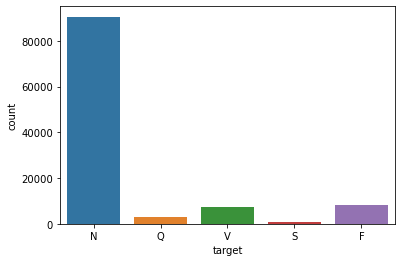

In [38]:
#Dataset_1 Model_2 Training without PCA
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

x_train_1_2,x_test_normal_1_2,x_test_anomaly_1_2=load_dataset_1()
model_1_2 =get_model_2(x_train_1_2.shape[1], x_train_1_2.shape[2],'Dataset_1')
checkpoint_filepath_1_2 = 'tmp/checkpoint'+'Dataset_1_model_2_'
model_checkpoint_callback_1_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath_1_2,save_weights_only=True,monitor='val_accuracy', mode='max',save_best_only=True)
history_1_2 = train_model(x_train_1_2,model_1_2,epochs,model_checkpoint_callback_1_2)


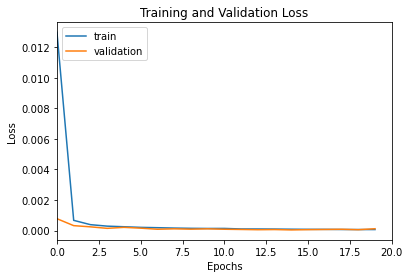

-------------Dataset-1_Model-2 Training Loss, No PCA-------------


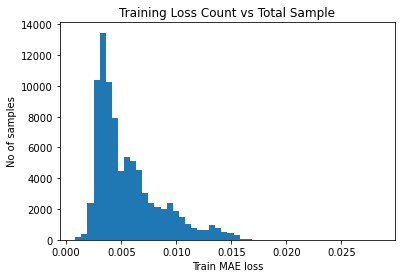

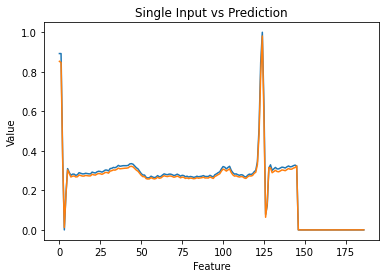

-------------Dataset-1_Model-2 Normal Prediction, No PCA-------------


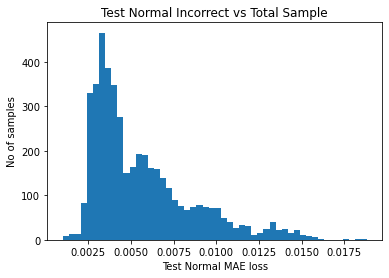

-------------Dataset-1_Model-2 Anomaly Prediction ,No PCA-------------


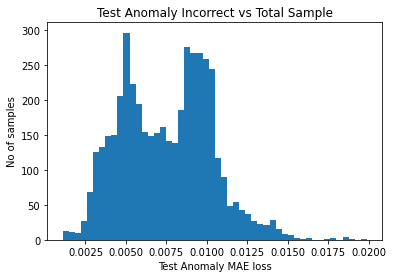

In [43]:
#Dataset_1 Model_2 Evaluation without PCA

plot_history(history_1_2 ,'Dataset-1_Model-2 Training Plot, No PCA')
train_x_pred_1_2,train_mae_loss_1_2 = get_training_loss(x_train_1_2,model_1_2,'Dataset-1_Model-2 Training Loss, No PCA')
plot_single_prediction(x_train_1_2[0], train_x_pred_1_2[0])
test_normal_mae_loss_1_2 = predict_normal(x_test_normal_1_2,model_1_2,'Dataset-1_Model-2 Normal Prediction, No PCA')
test_anomaly_mae_loss_1_2 = predict_anomaly(x_test_anomaly_1_2,model_1_2, len(x_test_normal_1_2),'Dataset-1_Model-2 Anomaly Prediction ,No PCA')

Reconstruction Threshold Value: 0.0057
Correct Predictions for normal samples :  2809
Normal Correct Percentage 62.00883002207506
Correct predictions for anomaly samples:  3066
Anomaly Correct Percentage 67.68211920529801
----------------Dataset-1_Model-2 Data vs Predictions,No PCA----------------


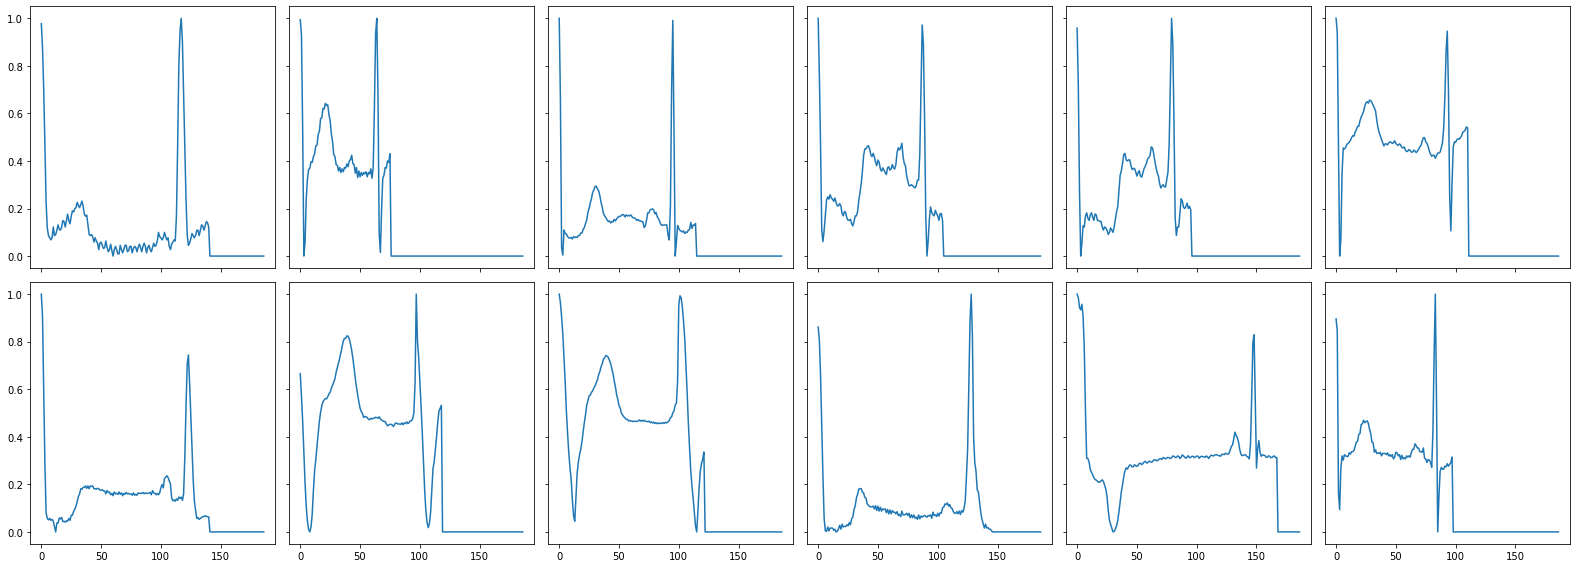

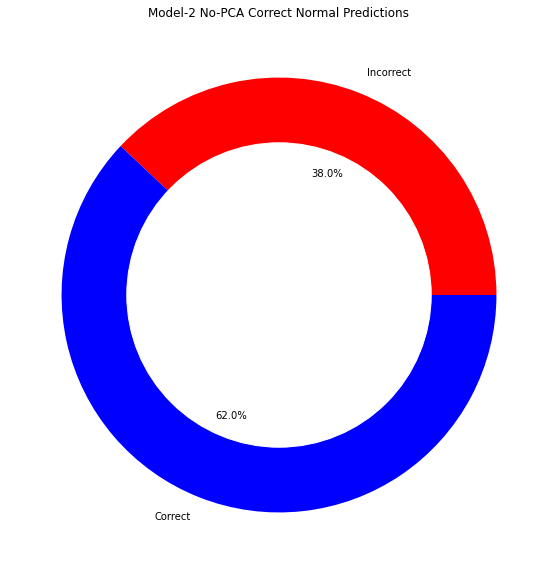

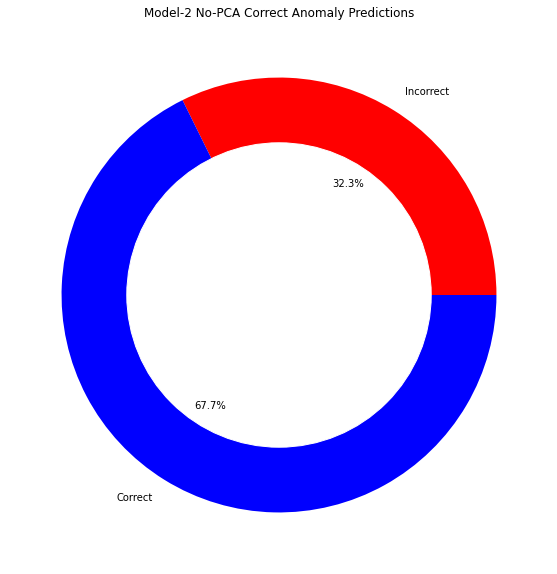

In [50]:
#Dataset_1 Model_4 without PCA Reconstruction Threshold Plots and Statistics
threshold_1_2 = 0.0057
plot_normal_anomaly(test_normal_mae_loss_1_2,test_anomaly_mae_loss_1_2,threshold_1_2,len(x_test_normal_1_2),'Dataset-1_Model-2 No-PCA Statistics')

plot_prdeict_normal_anomaly(x_test_normal_1_2,x_test_anomaly_1_2,model_1_2,'Dataset-1_Model-2 Data vs Predictions,No PCA')

normal_correct_count_1_2 = np.sum(test_normal_mae_loss_1_2 <= threshold_1_2)
anomaly_correct_count_1_2 = np.sum(test_anomaly_mae_loss_1_2 > threshold_1_2)

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.pie(np.array([len(x_test_normal_1_2)-normal_correct_count_1_2,normal_correct_count_1_2]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Model-2 No-PCA Correct Normal Predictions')
plt.show()
plt.figure(figsize=(20,10))
my_circle_a=plt.Circle( (0,0), 0.7, color='white')
plt.pie(np.array([len(x_test_normal_1_2)-anomaly_correct_count_1_2,anomaly_correct_count_1_2]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle_a)
plt.title('Model-2 No-PCA Correct Anomaly Predictions')
plt.show()

Data Sub-Types and Counts


/home/himadri/anaconda3/envs/anjana/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


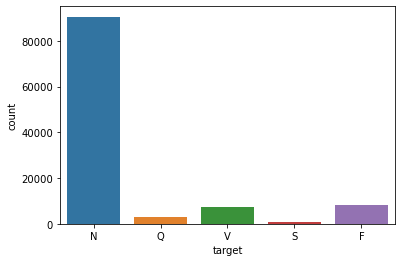

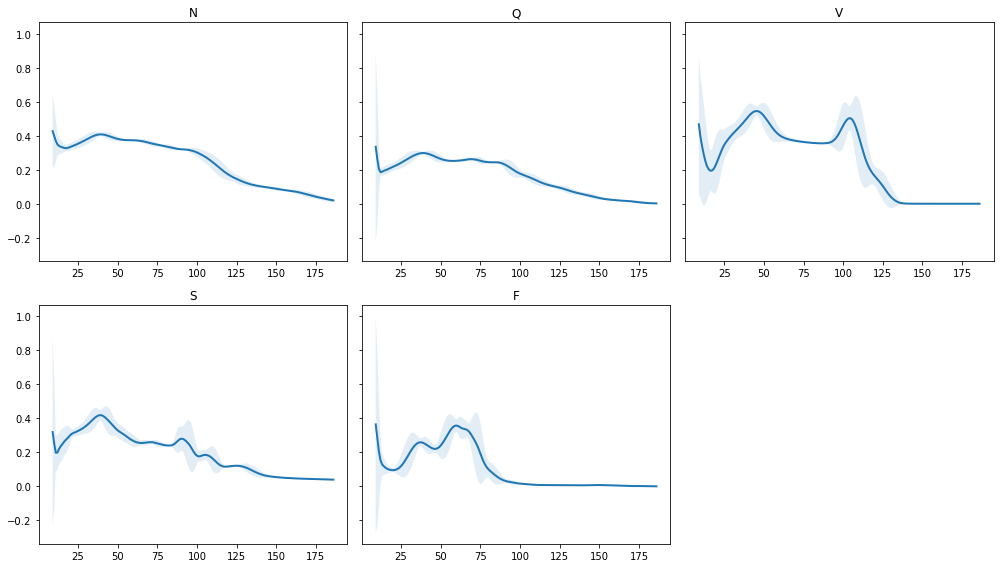

Merged Normal Shape (90589, 187)
Anomaly Shape (18857, 187)
Model: "model_1_Dataset_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 64)             384       
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 64)             20544     
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 6, 64)             20544     
_______________________________________________________

In [51]:
#Dataset_1 Model_1 Training with PCA
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

x_train_1_1,x_test_normal_1_1,x_test_anomaly_1_1=load_dataset_1_pca()
model_1_1 =get_model_1(x_train_1_1.shape[1], x_train_1_1.shape[2],'Dataset_1')
checkpoint_filepath_1_1 = 'tmp/checkpoint'+'Dataset_1_model_1_'
model_checkpoint_callback_1_1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath_1_1,save_weights_only=True,monitor='val_accuracy', mode='max',save_best_only=True)
history_1_1 = train_model(x_train_1_1,model_1_1,epochs,model_checkpoint_callback_1_1)

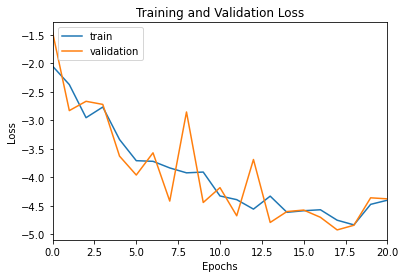

-------------Dataset-1_Model-1 Training Loss-------------


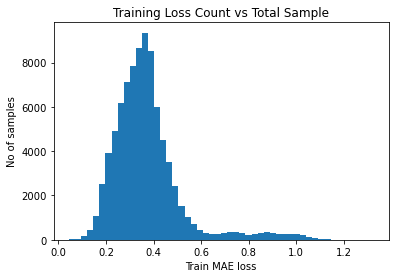

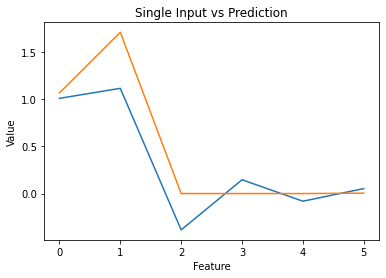

-------------Dataset-1_Model-1 Normal Prediction-------------


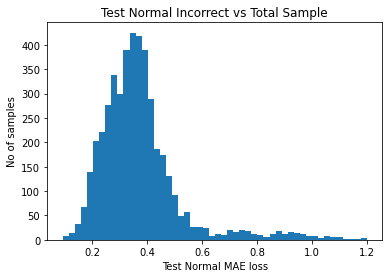

-------------Dataset-1_Model-1 Anomaly Prediction-------------


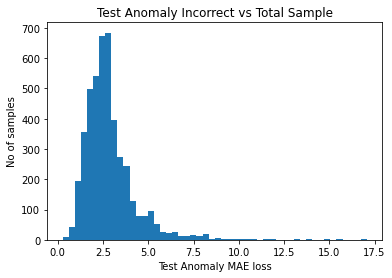

In [52]:
#Dataset_1 Model_1 Evaluation with PCA

plot_history(history_1_1 ,'Dataset-1_Model-1 Training Plot')
train_x_pred_1_1,train_mae_loss_1_1 = get_training_loss(x_train_1_1,model_1_1,'Dataset-1_Model-1 Training Loss')
plot_single_prediction(x_train_1_1[0], train_x_pred_1_1[0])
test_normal_mae_loss_1_1 = predict_normal(x_test_normal_1_1,model_1_1,'Dataset-1_Model-1 Normal Prediction')
test_anomaly_mae_loss_1_1 = predict_anomaly(x_test_anomaly_1_1,model_1_1, len(x_test_normal_1_1),'Dataset-1_Model-1 Anomaly Prediction')

Reconstruction Threshold Value: 0.881
Correct Predictions for normal samples :  4426
Normal Correct Percentage 97.70419426048565
Correct predictions for anomaly samples:  4494
Anomaly Correct Percentage 99.20529801324504


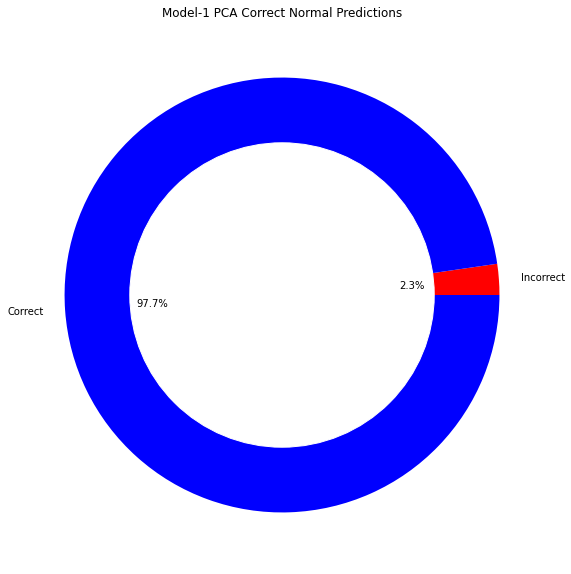

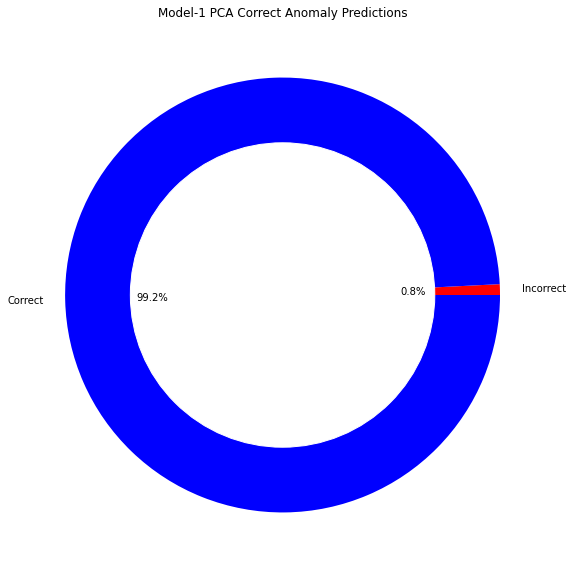

In [67]:
#Dataset_1 Model_1 Reconstruction Threshold Plots and Statistics
threshold_1_1 =0.881
plot_normal_anomaly(test_normal_mae_loss_1_1,test_anomaly_mae_loss_1_1,threshold_1_1,len(x_test_normal_1_1),'Dataset-1_Model-1 Statistics')
normal_correct_count_1_1 = np.sum(test_normal_mae_loss_1_1 <= threshold_1_1)
anomaly_correct_count_1_1 = np.sum(test_anomaly_mae_loss_1_1 > threshold_1_1)

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.pie(np.array([len(x_test_normal_1_1)-normal_correct_count_1_1,normal_correct_count_1_1]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Model-1 PCA Correct Normal Predictions')
plt.show()
plt.figure(figsize=(20,10))
my_circle_a=plt.Circle( (0,0), 0.7, color='white')
plt.pie(np.array([len(x_test_normal_1_1)-anomaly_correct_count_1_1,anomaly_correct_count_1_1]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle_a)
plt.title('Model-1 PCA Correct Anomaly Predictions')
plt.show()


Data Sub-Types and Counts


/home/himadri/anaconda3/envs/anjana/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


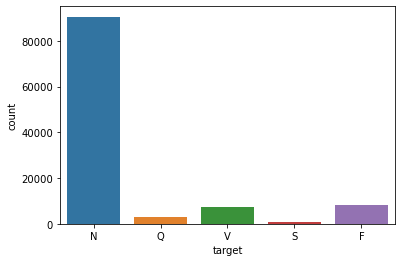

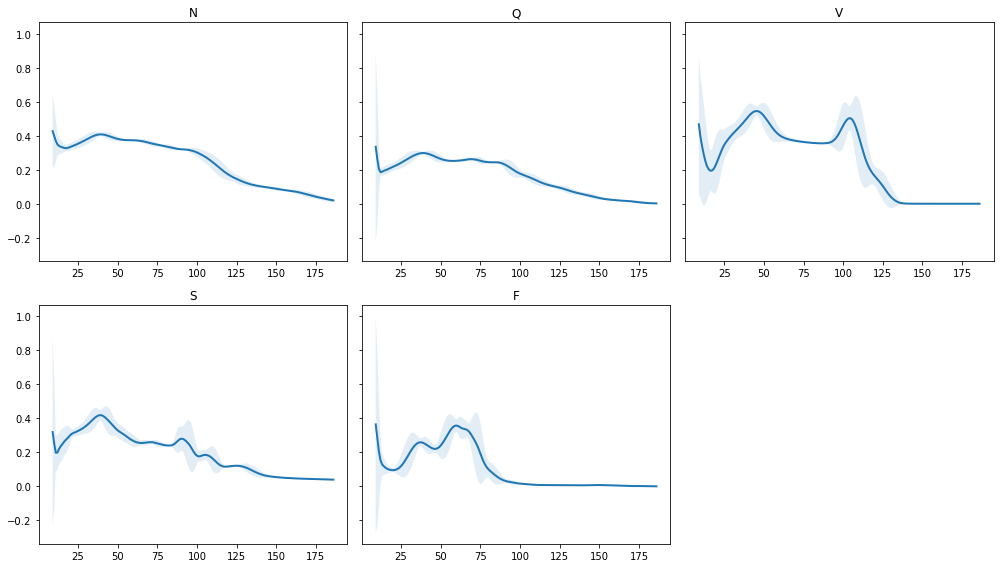

Merged Normal Shape (90589, 187)
Anomaly Shape (18857, 187)
Model: "model_2_Dataset_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6, 64)             384       
_________________________________________________________________
lstm_6 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 64)             20544     
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 6, 64)             20544     
_______________________________________________________

In [58]:
#Dataset_1 Model_2 Training with PCA
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

x_train_1_4,x_test_normal_1_4,x_test_anomaly_1_4=load_dataset_1_pca()
model_1_4 =get_model_2(x_train_1_4.shape[1], x_train_1_4.shape[2],'Dataset_1')
checkpoint_filepath_1_4 = 'tmp/checkpoint'+'Dataset_1_model_2_PCA_'
model_checkpoint_callback_1_4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath_1_4,save_weights_only=True,monitor='val_accuracy', mode='max',save_best_only=True)
history_1_4 = train_model(x_train_1_4,model_1_4,epochs,model_checkpoint_callback_1_4)

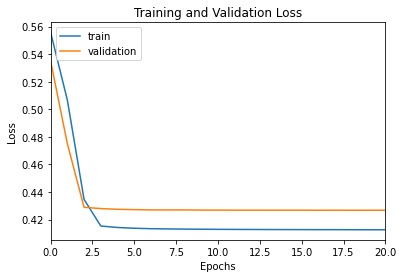

-------------Dataset-1_Model-2 Training Loss for PCA-------------


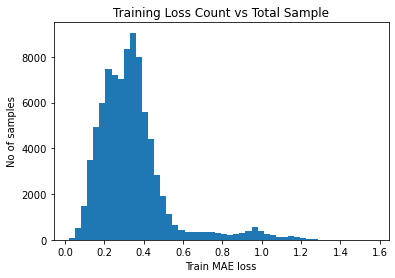

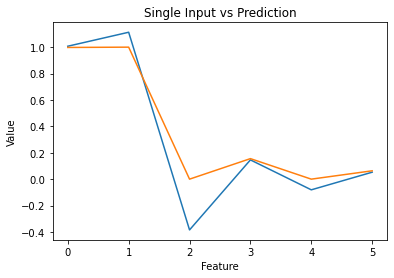

-------------Dataset-1_Model-2 Normal Prediction for PCA-------------


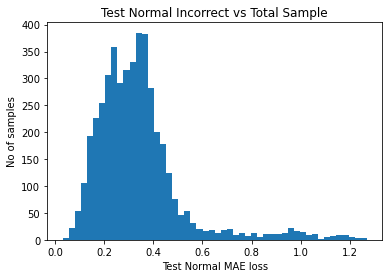

-------------Dataset-1_Model-2 Anomaly Prediction for PCA-------------


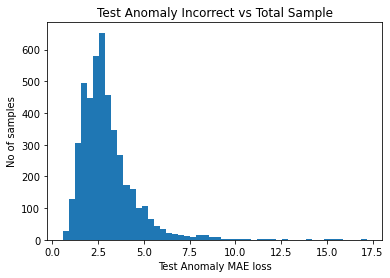

In [59]:
#Dataset_1 Model_2 Evaluation with PCA

plot_history(history_1_4 ,'Dataset-1_Model-2 Training Plot with PCA')
train_x_pred_1_4,train_mae_loss_1_4 = get_training_loss(x_train_1_4,model_1_4,'Dataset-1_Model-2 Training Loss for PCA')
plot_single_prediction(x_train_1_4[0], train_x_pred_1_4[0])
test_normal_mae_loss_1_4 = predict_normal(x_test_normal_1_4,model_1_4,'Dataset-1_Model-2 Normal Prediction for PCA')
test_anomaly_mae_loss_1_4 = predict_anomaly(x_test_anomaly_1_4,model_1_4, len(x_test_normal_1_4),'Dataset-1_Model-2 Anomaly Prediction for PCA')

Reconstruction Threshold Value: 0.93
Correct Predictions for normal samples :  4407
Normal Correct Percentage 97.28476821192052
Correct predictions for anomaly samples:  4495
Anomaly Correct Percentage 99.22737306843267


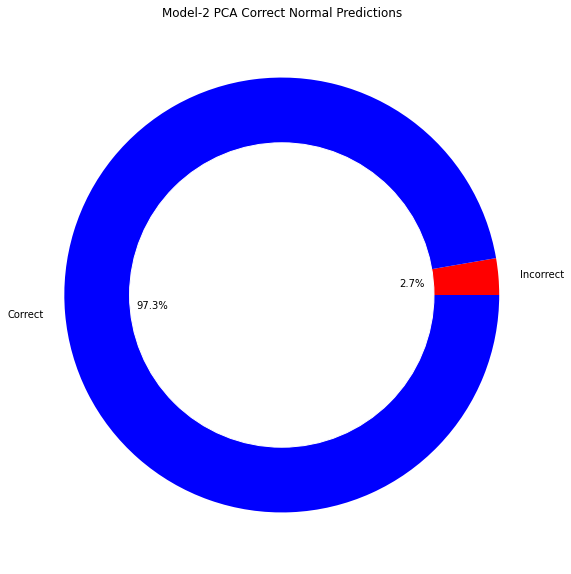

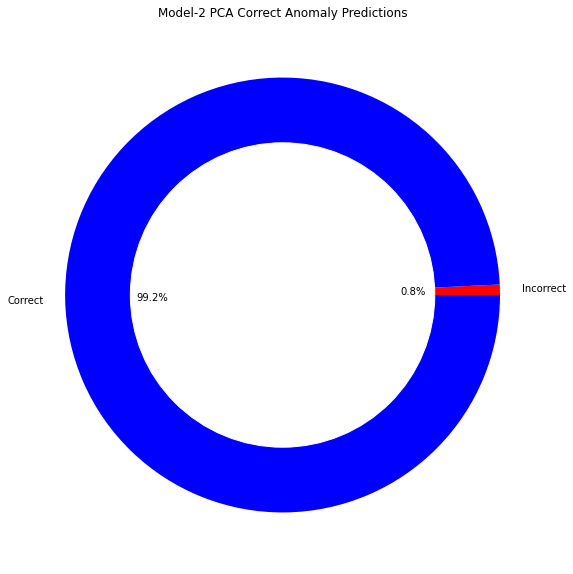

In [64]:
#Dataset_1 Model_2 Reconstruction Threshold Plots and Statistics with PCA
threshold_1_4 =0.93
plot_normal_anomaly(test_normal_mae_loss_1_4,test_anomaly_mae_loss_1_4,threshold_1_4,len(x_test_normal_1_4),'Dataset-1_Model-4 Statistics for PCA')


normal_correct_count_1_4 = np.sum(test_normal_mae_loss_1_4 <= threshold_1_4)
anomaly_correct_count_1_4 = np.sum(test_anomaly_mae_loss_1_4 > threshold_1_4)

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.pie(np.array([len(x_test_normal_1_4)-normal_correct_count_1_4,normal_correct_count_1_4]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Model-2 PCA Correct Normal Predictions')
plt.show()
plt.figure(figsize=(20,10))
my_circle_a=plt.Circle( (0,0), 0.7, color='white')
plt.pie(np.array([len(x_test_normal_1_4)-anomaly_correct_count_1_4,anomaly_correct_count_1_4]), labels=['Incorrect','Correct'], colors=['red','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle_a)
plt.title('Model-2 PCA Correct Anomaly Predictions')
plt.show()
